<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exercise-13" data-toc-modified-id="Exercise-13-1">Exercise 13</a></span></li><li><span><a href="#Train-test-split-(3:1)" data-toc-modified-id="Train-test-split-(3:1)-2">Train-test split (3:1)</a></span></li><li><span><a href="#Use-p-values-to-order-predictor-subsetting" data-toc-modified-id="Use-p-values-to-order-predictor-subsetting-3">Use p-values to order predictor subsetting</a></span></li><li><span><a href="#Plot-decision-boundary" data-toc-modified-id="Plot-decision-boundary-4">Plot decision boundary</a></span></li></ul></div>

# Exercise 13
##### Using the Boston data set, ﬁt classiﬁcation models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA, and KNN models using various subsets of the predictors. Describe your ﬁndings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
sns.set_context('notebook')
sns.set_palette('bone')
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm

In [2]:
boston = load_boston()
data = pd.DataFrame(boston.data, columns=boston.feature_names)
data['PRICE'] = boston.target
data.CRIM = (data.CRIM > data.CRIM.median()).astype(int)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Train-test split (3:1)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='CRIM'), data.CRIM, test_size=0.25)
print('Training set size:', len(X_train))
print('Testing set size:', len(X_test))

Training set size: 379
Testing set size: 127


# Use p-values to order predictor subsetting

In [4]:
glm = sm.GLM(y_train, X_train).fit()
print(glm.pvalues)

# Sorted predictors by statistical significance
predictors_list = list(glm.pvalues[1:].index[np.argsort(glm.pvalues[1:])])

ZN         6.200471e-02
INDUS      4.641593e-01
CHAS       7.786013e-01
NOX        1.565124e-08
RM         2.868218e-01
AGE        3.837842e-03
DIS        5.488624e-01
RAD        4.675742e-07
TAX        8.677999e-02
PTRATIO    1.168299e-01
B          2.641507e-02
LSTAT      9.789268e-01
PRICE      5.477655e-02
dtype: float64


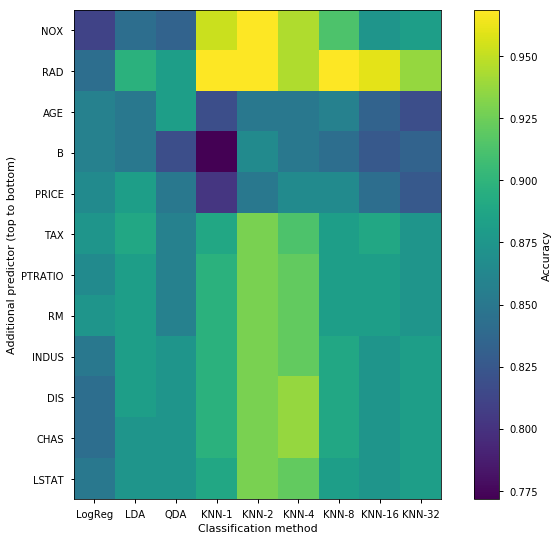

In [5]:
# Size of neighbourhood to test
knlist = [1, 2, 4, 8, 16, 32]
clf_list = ['LogReg', 'LDA', 'QDA'] + ['KNN-'+str(kn) for kn in knlist]

accuracy_mat = np.zeros((len(predictors_list), len(clf_list)))
precision_mat = np.zeros((len(predictors_list), len(clf_list)))
predictors = []

for i, pred in enumerate(predictors_list):
    
    predictors += [pred]  # cumulative list o predictors
    X_subset_train = X_train.filter(predictors).values.reshape(-1,len(predictors))
    X_subset_test = X_test.filter(predictors).values.reshape(-1,len(predictors))
        
    for j, clf in enumerate([LogisticRegression(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()] + [KNeighborsClassifier(kn) for kn in knlist]):
        clf.fit(X_subset_train, y_train)
        prediction = clf.predict(X_subset_test)
        accuracy_mat[i,j] = np.count_nonzero(prediction==y_test)/len(X_test)
        precision_mat[i,j] = np.count_nonzero(prediction==y_test)/len(X_test)
        
fig, ax = plt.subplots(figsize=(12,9))
imax = ax.imshow(accuracy_mat)
cax = fig.colorbar(imax)
cax.set_label('Accuracy')
ax.set_yticks(np.arange(len(predictors_list)))
ax.set_yticklabels(predictors_list)
ax.set_ylabel('Additional predictor (top to bottom)')
ax.set_xticks(np.arange(len(clf_list)))
ax.set_xticklabels(clf_list)
ax.set_xlabel('Classification method')
plt.show()

##### Using KNN with small neighbourhood, NOX (nitric oxides concentration (parts per 10 million)) and RAD (index of accessibility to radial highways) predicts CRIM (per capita crime rate by town) very well

In [6]:
X = data.filter(['NOX', 'RAD'])
y = data.CRIM

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print('Training set size:', len(X_train))
print('Testing set size:', len(X_test))

Training set size: 379
Testing set size: 127


# Plot decision boundary

In [7]:
def make_mesh(x, step_size=0.1, dim=2):
    '''Make mesh grid out of the first 2 predictors.
    x : feature matrix'''
    import numpy as np
    x_min = np.min(x, axis=0)
    x_max = np.max(x, axis=0)
    x_samples = [np.arange(mi - step_size, ma + step_size, step_size)
                 for mi, ma in zip(x_min, x_max)]
    x_mesh = np.stack(np.meshgrid(*x_samples[:dim]), axis=-1)
    return x_mesh

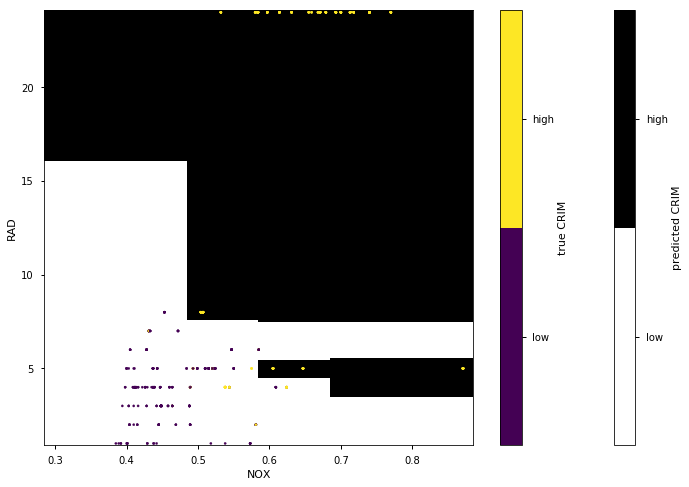

In [8]:
clf = KNeighborsClassifier(1)
clf.fit(X_train, y_train)

x_mesh = make_mesh(X, step_size=0.1)
X0 = x_mesh[0,:,0]
X1 = x_mesh[:,1,1]
pred_mesh = clf.predict(x_mesh.reshape(-1,2)).reshape(x_mesh.shape[:2])

fig, ax = plt.subplots(figsize=(12,8))

axim = ax.pcolor(X0, X1, pred_mesh, cmap=cm.get_cmap('Greys', 2))
cax = fig.colorbar(axim)
cax.set_label('predicted CRIM')
cax.set_ticks([0.25,0.75])
cax.set_ticklabels(['low', 'high'])

axim2 = ax.scatter(X.NOX.values, X.RAD.values, c=y.values, s=5, cmap=cm.get_cmap('viridis', 2))
cax2 = fig.colorbar(axim2)
cax2.set_label('true CRIM')
cax2.set_ticks([0.25,0.75])
cax2.set_ticklabels(['low', 'high'])

ax.set_xlabel('NOX')
ax.set_ylabel('RAD')

plt.show()